# <span style='color:red'>Project 2.  Due October 23</span>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

/var/folders/4h/7lpvz5hx3vg_wnfcn46rhlb00000gn/T/ipykernel_10258/1189900070.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### In this project we develop a first-order algorithm to construct a portfolio using intraday data.

In [2]:
import csv
import sys
import scipy.io
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from scipy.optimize import minimize

##### We will have data involving $n$ assets, and use the first $T$ days of the data to compute the portfolio.
##### The computation will produce a weight $x_i$ for each asset $i = 1,...,n$, which could be long or short.
##### We assume that on each day, a position is taken at the open, and closed at noon.  So we define:
$$ p^o_{j,t} = \ \text{price of asset $j$ on day $t$ at the open}$$
$$ p^1_{j,t} = \ \text{price of asset $j$ on day $t$ at noon}$$
$$ r_{j,t} =  \ \frac{p^1_{j,t} - p^o_{j,t}}{p^o_{j,t}} = \ \text{return earned by asset $j$ on day $t$.}$$
$$ \bar r_j = \ \frac{1}{T} \sum_{t = 1}^T r_{j,t} = \ \text{average return earned by asset $j$.}$$

#### The optimization problem to solve depends on two parameters: $\theta \ge 0$ and $\pi > 0 0$.
####
$$ \text{minimize} \ \left(-\sum_{j = 1}^n \bar r_j x_j\right) \ + \ \theta \left( \frac{1}{T} \sum_{t = 1}^{T}\left[\sum_{j = 1}^n (r_{j,t} -  \bar r_j)x_j\right]^\pi\right)^{1/\pi}$$
#### 
#### There are no constraints on the quantities $x_j$.
#### The first sum is minus the average return earned by the portfolio.  In the second sum, the quantity inside the square brackets is the excess return earned by the portfolio on day $t$, magnified by the power $\pi$.  The quantity $\theta$ is a risk aversion parameter.
 

In [3]:
def filt(df):
    dt = pd.to_datetime(df['Dates'])

    filt1 = (
        (dt.dt.time == datetime.time(9, 30)) | 
        (dt.dt.time == datetime.time(12, 0)) 
    )
    return filt1

def csvProcess(filename):
    df = pd.read_csv(filename, low_memory=False,header=3)
    df.loc[0,'Dates'] = df.loc[1,'Dates'].replace('31','30')
    if filename == 'AMZN.csv':
        df.loc[df['Dates'] == '4/20/2021 12:01', 'Dates'] = '4/20/2021 12:00'
        df.loc[df['Dates'] == '6/14/2021 12:01', 'Dates'] = '6/14/2021 12:00'
    numactual = df.iloc[:, 6].astype(float).isna().argmax()
    df = df.iloc[:numactual,:3]
    df.set_index(pd.to_datetime(df['Dates']), inplace=True)
    filt1 = filt(df)
    df = df.loc[filt1,'Close']  # set 'Dates' column as index
    return df


def reduced_evalgrad(x, ret, pi, theta):
    r_bar = np.mean(ret, axis=0) 
    excess_ret = ret-r_bar 
    g1 = np.array([-r_bar[0]+r_bar[2], -r_bar[1]+r_bar[2]])
    f2 = (np.vstack([excess_ret[:,0]-excess_ret[:,2], excess_ret[:,1]-excess_ret[:,2]])).T.dot(x)+excess_ret[:,2]
    g2 = np.sum(f2**pi)**(1/pi-1)
    g3 = (f2**(pi-1)).dot(np.vstack([excess_ret[:,0]-excess_ret[:,2], excess_ret[:,1]-excess_ret[:,2]]).T)
    return g1+(theta/T**(1/pi))*g2*g3

def reduced_evalfun(x, ret, pi, theta):
    r_bar = np.mean(ret, axis=0) 
    excess_ret = ret-r_bar 
    f1 = np.array([-r_bar[0]+r_bar[2], -r_bar[1]+r_bar[2]]).dot(x)-r_bar[2]
    f2 = (np.vstack([excess_ret[:,0]-excess_ret[:,2], excess_ret[:,1]-excess_ret[:,2]])).T.dot(x)+excess_ret[:,2]
    f3 = np.mean(f2**pi)**(1/pi)
    return f1+theta*f3

'''       
def evalfun(x, ret, pi, theta):
    term1 = -np.sum(np.mean(ret, axis = 0) * x)
    inner_sum = np.sum((ret - np.mean(ret, axis = 0)) * x, axis=1)
    term2 = np.power(np.mean(np.power(np.abs(inner_sum), pi)), 1/pi)
    return term1 + theta * term2

def evalgrad(x, ret, pi, theta):
    r_bar = np.mean(ret, axis=0)
    
    grad1 = -r_bar
    inner_sum = np.sum((ret - r_bar) * x, axis=1)
    
    grad2p2 = pi * np.mean(np.power(inner_sum, pi - 1)[:, np.newaxis] * (ret - r_bar), axis=0)
    grad2p1 = np.power(np.mean(np.power(inner_sum,pi),axis=0),(1-pi)/pi)
    grad2 = grad2p1*(theta/pi)*grad2p2
    return grad1 + grad2
'''

'       \ndef evalfun(x, ret, pi, theta):\n    term1 = -np.sum(np.mean(ret, axis = 0) * x)\n    inner_sum = np.sum((ret - np.mean(ret, axis = 0)) * x, axis=1)\n    term2 = np.power(np.mean(np.power(np.abs(inner_sum), pi)), 1/pi)\n    return term1 + theta * term2\n\ndef evalgrad(x, ret, pi, theta):\n    r_bar = np.mean(ret, axis=0)\n    \n    grad1 = -r_bar\n    inner_sum = np.sum((ret - r_bar) * x, axis=1)\n    \n    grad2p2 = pi * np.mean(np.power(inner_sum, pi - 1)[:, np.newaxis] * (ret - r_bar), axis=0)\n    grad2p1 = np.power(np.mean(np.power(inner_sum,pi),axis=0),(1-pi)/pi)\n    grad2 = grad2p1*(theta/pi)*grad2p2\n    return grad1 + grad2\n'

### <span style='color:red'> Task 1. Develop a first-order method to address this computational problem.</span>
#### 
#### Your method should work with values of $T$ at least $100$. Use the data we provide for AMZN, NFLX, TSLA, i.e., $n = 3$. 
###
#### Make sure your code works with $\pi = 0.5, 2, 4, 6$, and $\theta = 0.1, 10, 1000, 10^5, 10^6$.

In [4]:

def backtrack(x, ret, pi, theta, fval, g, delta): 
    alpha = 0.5
    beta = 0.75
    gradtimesdelta = g@delta#grad.dot(delta)
    t = 1 # One step 
    goon = True
    success = False
    while goon:
        fnew = reduced_evalfun(x + t*delta, ret, pi, theta)
        target = alpha*t*gradtimesdelta 
        if fnew - fval <= target: #target means the difference that is acceptable between fnew and fval?
            goon = False
            success = True   #accept if small enough?
        else:
            t = beta*t
        if t < 1e-6: #1e-4:
            if fnew < fval:
                print('well, we will take it\n')  #accept if t is small enough that will not make much progress
                success = True
            goon = False
    return t, success


In [5]:
def run_grad_descent(x, ret, pi, theta, xsol, fvalsol, loudsteps):
    converged = False 
    for iteration in range(N):

        #initialize everything
        xsol[iteration] = x
        fval = reduced_evalfun(x, ret, pi, theta)
        fvalsol[iteration] = fval
        g = reduced_evalgrad(x, ret, pi, theta)

        # print the progress every 50 iterations
        if loudsteps or 0 == iteration%50: 
            print('\nIteration', iteration)
            print('at x = ({:.5e}, {:.5e}) function value = {:.4e} and gradient = ({:.5e}, {:.5e})'.format(x[0],x[1],fval, g[0],g[1]))

        delta = -g  


        t, goodstep = backtrack(x, ret, pi, theta,fval,g,delta)

        if loudsteps:
            print('  got t = {:.4e} and goodstep = {}'.format(t, goodstep))
        if goodstep:
            newx = x + t*delta
            newfval = reduced_evalfun(x + t*delta, ret, pi, theta)
            if loudsteps or 0 == iteration%50:
                print('at new solution x = ({:.4e}, {:.4e}) function takes value {:.4e}'.format(newx[0], newx[1],newfval))
            x = newx
            if np.sum(np.power(g,2)) < 1e-8:
                converged = True
                break
    x = np.append(x, 1 - np.sum(x))
    print('\n*** Done at iteration {} and converged {} with final gradient ( {}, {})\n'.format(iteration,converged, g[0],g[1]))
    return iteration,x


In [6]:
# Task 1 test
#initialize
filename=['AMZN.csv','NFLX.csv','TSLA.csv']
T = 100
pi = 2
theta = 10
portfolio = [1 / 3, 1 / 3]
N = 500

returnarray = pd.DataFrame
price1 = csvProcess(filename[0])
price2 = csvProcess(filename[1])
price3 = csvProcess(filename[2])

returnarray = pd.concat([price1, price2, price3], axis=1)
# 显示所有列
pd.set_option('display.max_columns',None)
# 显示所有行
pd.set_option('display.max_rows',None)

print(price1)
print(returnarray.dropna())

test = returnarray.dropna().iloc[2*T:,:].reset_index(drop = True)
returnarray = returnarray.dropna().pct_change().reset_index(drop = True)
returnarray = np.array(returnarray[returnarray.index%2==1])
ret = returnarray[:T]

xsol = np.zeros((N,2))
fvalsol = np.zeros(N)
iteration, optimized_portfolio = run_grad_descent(portfolio, ret, pi, theta, xsol, fvalsol, True)
print('portfolio: {}'.format(optimized_portfolio))

Dates
2021-01-04 09:30:00    3262.80
2021-01-04 12:00:00    3174.25
2021-01-05 09:30:00    3174.80
2021-01-05 12:00:00    3197.00
2021-01-06 09:30:00    3146.17
2021-01-06 12:00:00    3179.75
2021-01-07 09:30:00    3162.20
2021-01-07 12:00:00    3194.78
2021-01-08 09:30:00    3173.77
2021-01-08 12:00:00    3157.74
2021-01-11 09:30:00    3143.11
2021-01-11 12:00:00    3149.62
2021-01-12 09:30:00    3124.00
2021-01-12 12:00:00    3105.25
2021-01-13 09:30:00    3126.25
2021-01-13 12:00:00    3177.54
2021-01-14 09:30:00    3162.00
2021-01-14 12:00:00    3146.90
2021-01-15 09:30:00    3133.61
2021-01-15 12:00:00    3108.28
2021-01-19 09:30:00    3123.32
2021-01-19 12:00:00    3117.17
2021-01-20 09:30:00    3177.17
2021-01-20 12:00:00    3233.77
2021-01-21 09:30:00    3293.16
2021-01-21 12:00:00    3325.99
2021-01-22 09:30:00    3293.84
2021-01-22 12:00:00    3303.66
2021-01-25 09:30:00    3335.16
2021-01-25 12:00:00    3291.16
2021-01-26 09:30:00    3296.14
2021-01-26 12:00:00    3306.14
20

[[ 1.59824661e-02  8.63236670e-03  1.62741531e-02]
 [-3.26470588e-04  2.50697924e-02  3.93644449e-02]
 [-6.97158056e-03 -1.17606365e-02 -9.87383747e-03]
 [-1.58230704e-03 -1.93530550e-03 -1.32578422e-02]
 [ 4.46051838e-03 -3.13390933e-03  1.59203686e-02]
 [-1.27933357e-02 -5.18960630e-03 -6.34123065e-03]
 [-3.13753884e-04  1.39606654e-02 -8.47141190e-03]
 [-1.19692065e-02 -9.38454436e-03 -4.23789794e-02]
 [-4.71956474e-03 -1.46062247e-02 -1.14821854e-03]
 [ 2.01353440e-03 -9.42857143e-03  1.06540881e-02]
 [-1.31317151e-03 -1.36706629e-03 -2.65468330e-02]
 [ 1.53256470e-02 -1.60403498e-02  4.96813981e-03]
 [ 9.34969759e-03 -1.16297072e-02  4.51426968e-03]
 [-6.33627246e-03 -1.01714724e-02 -9.20920165e-03]
 [-4.00703492e-03 -1.96239674e-04 -2.10615516e-02]
 [ 3.19259089e-03  9.96910051e-03  1.09541069e-02]
 [-5.28046764e-03  2.00980483e-02  2.12621278e-02]
 [-9.23220085e-03 -5.21726440e-03 -3.16335709e-02]
 [ 4.89967638e-03  3.04777895e-03 -1.63824474e-02]
 [-2.06526493e-03  1.23418245e-

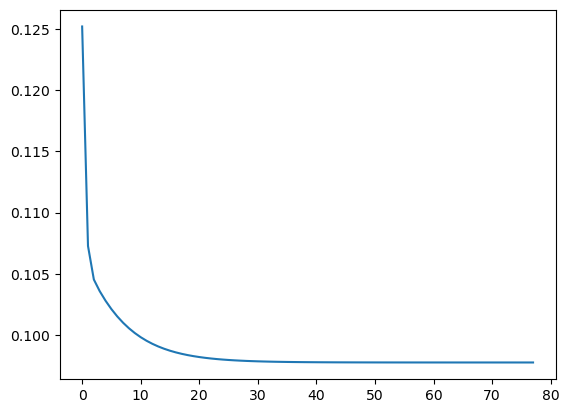

In [7]:
plt.plot(fvalsol[:iteration+1])
print(returnarray[:T])

### <span style='color:red'>Task 2: Benchmark your portfolio on the remaining days</span>
#### On each of the remaining days, we proceed as follows.  Denote by $x^*$ your portfolio. At the market open we invest $10^9 x^*_j$ on each asset $j$, and we close the position (by) noon.  You need to use the asset's price to compute the number of shares that you invest in, whether long or short. So the total you invest equals $$ \sum_{j = 1}^n 10^9 |x^*_j|.$$
#### Report the average return earned by your portfolio.

Average return rate of the portfolio is given by the formula:$$ R_p = \sum_{i=1}^n w_i r_i $$
where $w_i$ refers to the weight of each assess in the portfolio and $r_i$ refers to the average return of each asset


In [10]:
'''
def benchmark(optimized_portfolio,test):
    test.columns=['AMZN','NFLX','TSLA']
    numofshares = (1e9*optimized_portfolio)/test[test.index%2==0].reset_index(drop=True)  # Find number of shares for each day and asset
    restreturn = test.pct_change()
    restreturn = np.mean(np.array(restreturn[restreturn.index%2==1].reset_index(drop=True)),axis=0)
    weight_normalized = optimized_portfolio/(np.sum(np.power(optimized_portfolio,2))**(1/2))
    averagereturn = restreturn@weight_normalized
    return numofshares,averagereturn
'''
def benchmark(optimized_portfolio,test):
    numofshares = (1e9*optimized_portfolio)/test[test.index%2==0].reset_index(drop=True)
    repeatnumofshares = np.array(pd.DataFrame(np.repeat(numofshares.values,2,axis = 0)))
    testreturn = test.pct_change()
    testreturn = np.sum(np.array(testreturn[testreturn.index%2==1].reset_index(drop=True)),axis=1)
    return numofshares,np.mean(testreturn)

In [11]:
# Task 2 Test
numofshares, averagereturn = benchmark(optimized_portfolio,test)
print(numofshares)
print('Average Return of the Portfolio is: {}'.format(averagereturn))

            Close          Close         Close
0   244860.844636  330017.999354 -31031.498529
1   247663.865132  328773.118180 -31730.851285
2   246273.352750  327870.269080 -31131.395535
3   245869.444292  327095.074794 -31245.438306
4   246191.749344  331108.739997 -31142.944273
5   245486.778650  324464.870931 -31309.208252
6   238618.656624  326770.095152 -31184.663740
7   227126.154957  321312.984570 -32180.509752
8   231872.742783  327820.941172 -33946.915377
9   227779.704430  328680.130591 -32495.846282
10  226097.293561  323813.915996 -32118.320556
11  228376.664846  324615.928153 -30973.532041
Average Return of the Portfolio is: 0.0007572447427614722
